In [1]:
import torch
from torch import ones, zeros, tensor, eye

from torch.distributions import Categorical

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='white', palette='colorblind', color_codes=True)

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/control_dilemmas')])

from befit.simulate import Simulator
from befit.tasks import bandits
from befit.agents import AIBanditsNaive, AIBanditsFlat, Random

from setup_environment import *

context = torch.from_numpy(np.load('context.npy'))
offers = torch.from_numpy(np.load('offers.npy'))

In [2]:
a = 2*torch.stack([torch.eye(nf), torch.eye(nf)]).reshape(-1, 3)[arm_types] + 1
a = a.repeat(nsub, 1, 1, 1)

lam = torch.tensor([1., 0.])

pars = {
    'nd': 10,
    'ns': 4,  # number of arm types
    'na': na,
    'nc': 6,  # number of contexts
    'nf': nf,
    'ni': len(lam),  # internal states change preference over features, for now they match number of features
}

nd = 10
Bdd = zeros(nd, nd)

d = torch.arange(1., nd+1.)

s = [.1, 10.]
m = [1.6, 5.]
Bdd[range(1, nd), range(nd-1)] = 1.

Bccd = zeros(nd, 6, 6)
Bccd[0] = (ones(6, 6) - eye(6))/5
Bccd[1:] = eye(6).repeat(nd-1, 1, 1)

agents = []
envs = []
for i in range(len(m)):
    Bdd[0] = (-(d.log()-m[i])**2/s[i] - d.log() ).softmax(-1)
    tm_higher = {
        'context': Bccd,
        'duration': Bdd.clone()
    }

    agents.append(AIBanditsFlat(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher}))
    agents[-1].set_parameters(x = [a], depth=trials, lam=lam)

    envs.append(bandits.MultiArmedBandit(priors, 
                                transitions, 
                                context,
                                offers,
                                arm_types,
                                nsub=nsub, 
                                blocks=blocks, 
                                trials=trials))

sim = Simulator(envs, agents, runs=nsub, blocks=blocks, trials=trials)
sim.simulate_experiment()

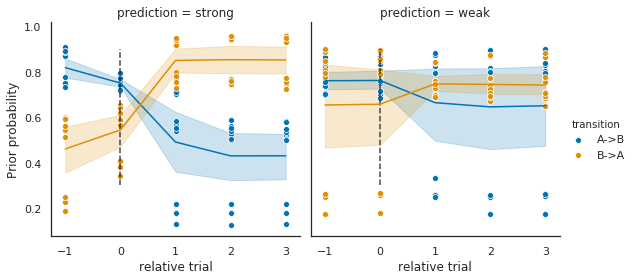

In [3]:
import pandas as pd

cut = 20
offs = offers[:, 0, 0].reshape(-1, 5)[-cut-1:, 0]
rt = torch.arange(-1, 4)

dfs = pd.DataFrame()
name = ['strong', 'weak']
for i in range(len(agents)):
    internals = torch.stack(agents[i].priors['internals'])
    mi, _ = internals[4:-1].reshape(-1, 5, nsub, 2)[-cut:].median(-2)


    for j in range(cut):
        dct = {
                'relative trial': rt,
                'Prior probability':mi[j, :, 1],
                'prediction': name[i],
                'transition': 'B->A' if offs[j] in [1, 3, 5] else 'A->B'
        }
        dfs = dfs.append(pd.DataFrame(dct), ignore_index=True)
        
g = sns.FacetGrid(dfs, col='prediction', hue='transition', height=4, aspect=1)

g = g.map(sns.lineplot, 'relative trial', 'Prior probability')
g = g.map(sns.scatterplot, 'relative trial', 'Prior probability').add_legend()


for ax in g.axes[0]:
    ax.vlines(0, .3, .9, 'k', linestyle='--', alpha=.8)
    
g.savefig('prior_expectations.png', bbox_inches='tight', transparent=True, dpi=300)

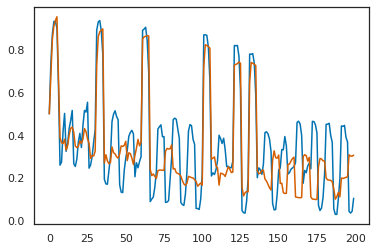

In [6]:
internals1 = torch.stack(agents[0].priors['internals'])
internals2 = torch.stack(agents[1].priors['internals'])

plt.plot(internals1.median(-2)[0][:, 0].numpy(), 'b');
plt.plot(internals2.median(-2)[0][:, 0].numpy(), 'r');



